# Аналитика в Яндекс.Афише

## Описание проекта
Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.

У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Вы изучите:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент
* когда клиент окупается.

## Инструкция по выполнению проекта:

### Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:
* /datasets/visits_log.csv
* /datasets/orders_log.csv
* /datasets/costs.csv

### Шаг 2. Постройте отчёты и посчитайте метрики
Продукт
* Сколько людей пользуются в день, неделю, месяц?
* Сколько сессий в день?
* Сколько длится одна сессия?
* Как часто люди возвращаются?

Продажи
* Когда люди начинают покупать?
* Сколько раз покупают за период?
* Какой средний чек?
* Сколько денег приносят? (LTV)

Маркетинг
* Сколько денег потратили? Всего / на каждый источник / по времени
* Сколько стоило привлечение одного покупателя из каждого источника?
* На сколько окупились расходы? (ROI)

Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

### Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?
Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

**Оформление:** Задание выполните в Jupyter Notebook. Программный код заполните в ячейках типа code, текстовые пояснения — в ячейках типа markdown. Примените форматирование и заголовки.

### Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):
* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from IPython.core.display import display, HTML
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [2]:
# библиотека переиспользуемых самописных функций

def df_info(df):
    """вывод базовой инфы по датафрейму"""
    df.info()
    display(df.describe())
    display(df)
    
def normal_df(df):
    """приводим имена колонок к ниженему регистру, убираем пробелы и обрабатываем даты в колонках *_ts"""
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.columns
    for col in df.columns:
        if col.endswith('_ts'):
            df[col] = pd.to_datetime(df[col])
            df[col+'_month'] = df[col].astype('datetime64[M]')
    return df

def print_min_max(series, label):
    """выводим минимум и максимум для Series"""
    print('{}: min={} max={}'.format(label, series.min(), series.max()))

def show_html_tag(tag, text):
    """выводим text внутри тэга tag"""
    display(HTML('<' + tag + '>'+text+'</'+tag+'>'))
    

In [3]:
# делаем загрузку с разных путей в зависимости от того, где запущена тетрадка - локально или на сервере ЯП
root_local = 'datasets/' #путь к данным при локальном запуске
root_yp = '/datasets/' #путь к данным при запуске на сервере ЯП

username = ''
try:
    username = os.environ["USERNAME"]
except:
    pass
if(username == 'msn'): # локально
    root_path = root_local
else: # в тренажере
    root_path = root_yp

visits_df = pd.read_csv(root_path + 'visits_log.csv')
orders_df = pd.read_csv(root_path + 'orders_log.csv')
costs_df = pd.read_csv(root_path + 'costs.csv')


In [4]:
# слегка причёсываем данные
visits_df = normal_df(visits_df)
visits_df['day'] = visits_df['start_ts'].astype('datetime64[D]')
visits_df['week'] = visits_df['day'] - visits_df['day'].dt.weekday * np.timedelta64(1, 'D')


orders_df = normal_df(orders_df)
costs_df = normal_df(costs_df)
costs_df['dt'] = pd.to_datetime(costs_df['dt'])

## Взгляд на visits_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
device            359400 non-null object
end_ts            359400 non-null datetime64[ns]
source_id         359400 non-null int64
start_ts          359400 non-null datetime64[ns]
uid               359400 non-null uint64
end_ts_month      359400 non-null datetime64[ns]
start_ts_month    359400 non-null datetime64[ns]
day               359400 non-null datetime64[ns]
week              359400 non-null datetime64[ns]
dtypes: datetime64[ns](6), int64(1), object(1), uint64(1)
memory usage: 24.7+ MB


,source_id,uid
count,359400.00,359400.00
mean,3.75,9202556994354921472.00
std,1.92,5298432824659611648.00
min,1.00,11863502262781.00
25%,3.00,4613406732167550976.00
50%,4.00,9227412908740601856.00
75%,5.00,13728237011236173824.00
max,10.00,18446676030785673216.00


,device,end_ts,source_id,start_ts,uid,end_ts_month,start_ts_month,day,week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-01,2017-12-20,2017-12-18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-01,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-07-01,2017-06-26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-01,2018-05-20,2018-05-14
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-01,2017-12-27,2017-12-25
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-01,2017-07-01,2017-07-29,2017-07-24
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-01,2018-01-25,2018-01-22
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-01,2018-03-01,2018-03-03,2018-02-26
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-01,2017-11-01,2017-11-02,2017-10-30


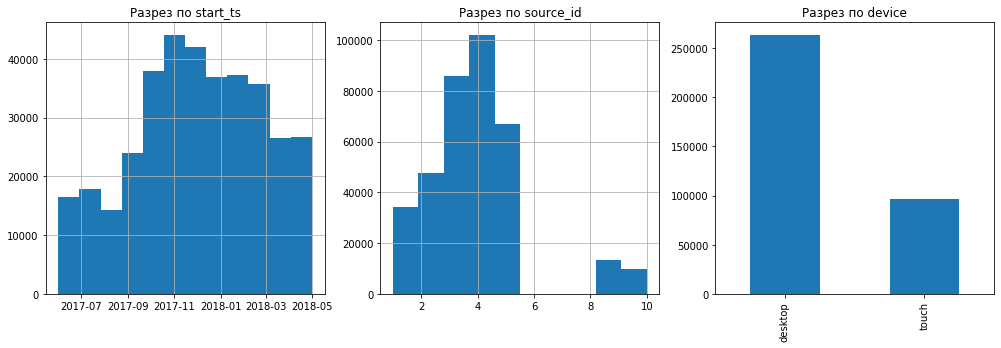

visits_df["start_ts"]: min=2017-06-01 00:01:00 max=2018-05-31 23:59:00
visits_df["end_ts"]: min=2017-06-01 00:02:00 max=2018-06-01 01:26:00


In [5]:
df_info(visits_df)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,5)) 

visits_df['start_ts_month'].hist(bins=12, ax = ax[0]).set_title('Разрез по start_ts')
visits_df['source_id'].hist(bins=10, ax = ax[1]).set_title('Разрез по source_id')
visits_df['device'].value_counts().plot.bar(ax = ax[2]).set_title('Разрез по device')
plt.show()

print_min_max(visits_df['start_ts'], 'visits_df["start_ts"]')
print_min_max(visits_df['end_ts'], 'visits_df["end_ts"]')


#### Вывод
* В таблице visits пропусков нет. 
* Данные покрывают интервал от июня 2017 до мая 2018, но дата окончания сессии несколько раз выскакивает на начало 01.06.2018.
* Имеется 9 различных источников (1..10 за исключением 8), но для 6 и 7 число записей мизерное относительно других источников.
* Девайсов 2 типа - desktop и touch. Десктопов примерно в 2,5 раза больше, чем тач устройств.

## Взгляд на orders_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 4 columns):
buy_ts          50415 non-null datetime64[ns]
revenue         50415 non-null float64
uid             50415 non-null uint64
buy_ts_month    50415 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.5 MB


,revenue,uid
count,50415.00,50415.00
mean,5.00,9098160634289729536.00
std,21.82,5285741550834715648.00
min,0.00,313578113262317.00
25%,1.22,4533566627250599936.00
50%,2.50,9102273602618561536.00
75%,4.89,13682901980465401856.00
max,2633.28,18446167067214817280.00


,buy_ts,revenue,uid,buy_ts_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01


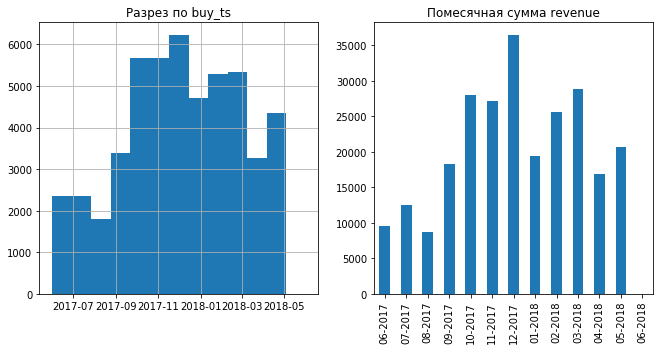

orders_df["buy_ts"]: min=2017-06-01 00:10:00 max=2018-06-01 00:02:00


In [6]:
df_info(orders_df)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5)) 

orders_df['buy_ts_month'].hist(bins=13, ax = ax[0]).set_title('Разрез по buy_ts')
temp_df = orders_df.groupby('buy_ts_month')['revenue'].sum()
temp_df.index = temp_df.index.strftime("%m-%Y")
temp_df.plot.bar(ax = ax[1]).set_title('Помесячная сумма revenue')
plt.show()

print_min_max(orders_df['buy_ts'], 'orders_df["buy_ts"]')

#### Вывод
* В таблице orders пропусков нет. 
* Данные покрывают интервал от июня 2017 до мая 2018 с маленьким выходом на 01.06.2018 (видимо сессия началась 31.05.2018, а покупка была сделана уже 01.06.2018).

## Взгляд на costs_df

In [7]:
df_info(costs_df)
costs_pivot = costs_df.pivot_table(index='dt', columns='source_id', values='costs')
costs_pivot['month'] = costs_pivot.index
costs_pivot['month'] = costs_pivot['month'].astype('datetime64[M]')

display(costs_pivot)
display(costs_pivot['month'].value_counts().reset_index().sort_values('index')) # в апреле 29 значений
costs_pivot.query('month == "2018-04-01"')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,costs
count,2542.00,2542.00
mean,4.86,129.48
std,3.18,156.30
min,1.00,0.54
25%,2.00,21.95
50%,4.00,77.30
75%,9.00,170.06
max,10.00,1788.28


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


source_id,1,2,3,4,5,9,10,month
dt,,,,,,,,
2017-06-01,75.20,132.56,349.38,76.74,73.24,13.06,15.08,2017-06-01
2017-06-02,62.25,132.38,314.22,59.21,123.82,18.13,11.18,2017-06-01
2017-06-03,36.53,77.20,196.12,59.39,64.93,7.06,9.62,2017-06-01
2017-06-04,55.00,79.08,389.87,161.97,52.77,4.65,17.82,2017-06-01
2017-06-05,57.08,108.96,424.47,44.65,144.30,15.30,26.68,2017-06-01
...,...,...,...,...,...,...,...,...
2018-05-27,30.89,113.35,254.90,28.04,84.66,11.11,9.92,2018-05-01
2018-05-28,54.47,82.67,247.92,68.88,131.77,12.47,21.26,2018-05-01
2018-05-29,61.13,105.75,347.59,103.84,138.33,16.83,11.32,2018-05-01


,index,month
8,2017-06-01,30
0,2017-07-01,31
1,2017-08-01,31
7,2017-09-01,30
5,2017-10-01,31
9,2017-11-01,30
3,2017-12-01,31
4,2018-01-01,31
11,2018-02-01,28
2,2018-03-01,31


source_id,1,2,3,4,5,9,10,month
dt,,,,,,,,
2018-04-02,15.67,90.86,317.38,65.09,63.05,12.44,21.25,2018-04-01
2018-04-03,42.96,83.54,506.88,56.98,117.10,12.57,23.96,2018-04-01
2018-04-04,55.59,92.35,517.14,51.62,108.56,9.18,4.87,2018-04-01
2018-04-05,43.52,123.88,225.38,226.01,88.85,8.42,17.33,2018-04-01
2018-04-06,54.06,126.38,486.80,118.28,118.16,16.81,6.84,2018-04-01
2018-04-07,44.17,62.95,295.39,36.92,90.99,8.91,3.36,2018-04-01
2018-04-08,28.57,111.13,75.90,45.96,85.60,10.23,7.30,2018-04-01
2018-04-09,21.56,160.18,275.62,364.56,122.59,15.63,16.25,2018-04-01
2018-04-10,41.21,97.32,451.91,199.19,116.01,20.11,7.31,2018-04-01


#### Вывод
* В таблице costs пропусков нет. 
* Данные покрывают интервал от 01.06.2017 до 31.05.2018. Но какой-то один день пропущен (всего 364 дня вместо 365). И этот день 1 апреля 2018.
* Так же отсутствуют source_id 6,7,8. При этом помним, что в логах у нас есть заходы с source_id равным 6 и 7. Видимо, они бесплатные

## Изучаем продукт

### Сколько людей пользуются в день, неделю, месяц?

In [8]:
def period_stat(df, period, column, text, func_count):
    """Вывод статистики по посетителям в period в разрезе column 
        df - датафрейм с данными
        period - период сбора статистики. совпадает с именем столбца 'day', 'week', 'start_ts_month' в исходном датафрейме
        column - столбец, в разрезе которого строится статистика. Если column == '', то без разреза, по всему датафрейму
        text - выводимый в качестве заголовка текст
        func_count - 'nunique' или 'count' - считаем уникальные или все заходы
    
    """
    show_html_tag('h4', text)

    # высчитываем абсолютные цифры в разрезе периода и (если надо) дополнительного столбца устройства/источник 
    if column != '': 
        visits_day = df.groupby([period, column]).agg(peoples = ('uid', func_count)).reset_index()
    else:
        visits_day = df.groupby(period).agg(peoples = ('uid', func_count)).reset_index()

    visits_day['month'] = visits_day[period].astype('datetime64[M]')
    
    # дневную статистику агрегирую по неделям, остальную помесячно.
    if period == 'day': 
        visits_day['quantum'] = visits_day['day'] - visits_day['day'].dt.weekday * np.timedelta64(1, 'D')
    else:
        visits_day['quantum'] = visits_day[period].astype('datetime64[M]')

    if column != '':
        visits_day_in_month = visits_day.pivot_table(index = 'quantum', columns = column, values = 'peoples', aggfunc='mean')
    else:
        visits_day_in_month = visits_day.pivot_table(index = 'quantum', values = 'peoples', aggfunc='mean')

    display(visits_day_in_month)
    
    # дополнительно прочситываем процентное распределение по доп столбцу внутри каждого периода. 
    data_perc = visits_day_in_month.divide(visits_day_in_month.sum(axis=1), axis=0)*100
    show_html_tag('h5', 'В процентах')
    display(data_perc)

    fig, ax = plt.subplots(ncols = 2, figsize=(17,5))
    
    fig.suptitle(text)
    visits_day_in_month.plot.area(ax = ax[0])
    
    data_perc.plot.area(ax = ax[1])

    plt.show()
    

    if column == '': # без дополнительного разреза - значит, посчитаем итоговую метрику за весь период.
        final = visits_day['peoples'].mean()
        show_html_tag('h5', text + ' в среднем за весь период: {:.0f}'.format(final))


,device,end_ts,source_id,start_ts,uid,end_ts_month,start_ts_month,day,week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-01,2017-12-20,2017-12-18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-01,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-07-01,2017-06-26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-01,2018-05-20,2018-05-14
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-01,2017-12-27,2017-12-25
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-01,2017-07-01,2017-07-29,2017-07-24
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-01,2018-01-25,2018-01-22
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-01,2018-03-01,2018-03-03,2018-02-26
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-01,2017-11-01,2017-11-02,2017-10-30


source_id,1,2,3,4,5,6,7,9,10
quantum,,,,,,,,,
2017-05-29,48.00,72.00,156.00,128.75,105.75,nan,nan,25.50,16.75
2017-06-05,58.14,87.14,207.86,147.71,119.71,nan,1.00,24.71,26.43
2017-06-12,35.43,62.57,120.71,131.43,57.71,nan,nan,18.57,14.29
2017-06-19,34.43,55.14,116.00,114.43,97.14,nan,1.00,24.86,10.00
2017-06-26,39.71,57.29,116.43,104.14,123.00,1.00,nan,34.71,8.86
2017-07-03,41.71,67.43,139.14,145.14,103.29,nan,1.00,21.71,9.71
2017-07-10,52.29,89.14,169.00,207.00,150.57,nan,nan,14.29,13.00
2017-07-17,57.57,89.57,154.29,140.14,142.71,nan,nan,26.00,14.29
2017-07-24,35.14,58.43,100.71,88.14,116.71,nan,1.00,16.71,8.00


source_id,1,2,3,4,5,6,7,9,10
quantum,,,,,,,,,
2017-05-29,8.68,13.03,28.22,23.29,19.13,nan,nan,4.61,3.03
2017-06-05,8.64,12.95,30.90,21.96,17.80,nan,0.15,3.67,3.93
2017-06-12,8.04,14.20,27.39,29.82,13.10,nan,nan,4.21,3.24
2017-06-19,7.60,12.17,25.61,25.26,21.44,nan,0.22,5.49,2.21
2017-06-26,8.19,11.81,24.00,21.47,25.35,0.21,nan,7.16,1.83
2017-07-03,7.88,12.74,26.30,27.43,19.52,nan,0.19,4.10,1.84
2017-07-10,7.52,12.82,24.31,29.77,21.66,nan,nan,2.05,1.87
2017-07-17,9.22,14.34,24.70,22.44,22.85,nan,nan,4.16,2.29
2017-07-24,8.27,13.75,23.71,20.75,27.47,nan,0.24,3.93,1.88


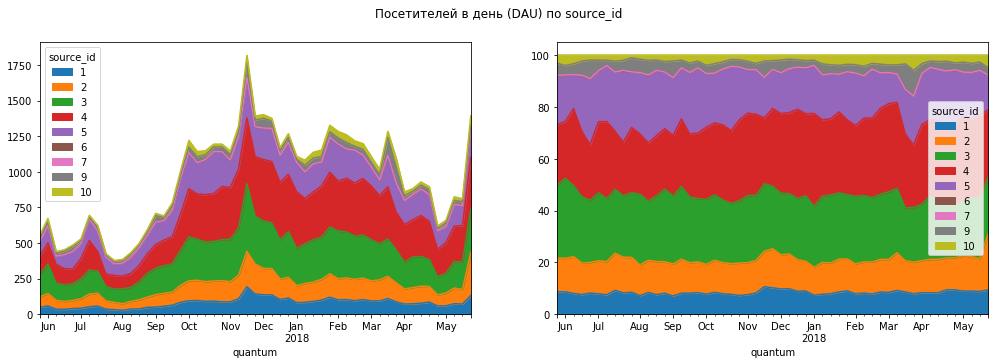

device,desktop,touch
quantum,,
2017-05-29,386.50,149.25
2017-06-05,480.57,169.71
2017-06-12,327.00,102.71
2017-06-19,323.00,115.86
2017-06-26,339.14,130.86
2017-07-03,379.71,132.71
2017-07-10,470.29,204.29
2017-07-17,431.43,169.14
2017-07-24,303.00,107.29


device,desktop,touch
quantum,,
2017-05-29,72.14,27.86
2017-06-05,73.90,26.10
2017-06-12,76.10,23.90
2017-06-19,73.60,26.40
2017-06-26,72.16,27.84
2017-07-03,74.10,25.90
2017-07-10,69.72,30.28
2017-07-17,71.84,28.16
2017-07-24,73.85,26.15


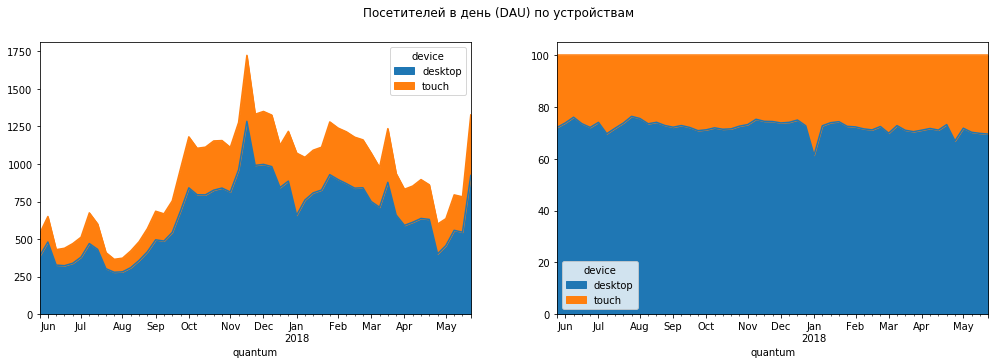

,peoples
quantum,
2017-05-29,533.50
2017-06-05,645.86
2017-06-12,429.29
2017-06-19,438.57
2017-06-26,468.71
2017-07-03,511.00
2017-07-10,672.29
2017-07-17,597.29
2017-07-24,409.00


,peoples
quantum,
2017-05-29,100.00
2017-06-05,100.00
2017-06-12,100.00
2017-06-19,100.00
2017-06-26,100.00
2017-07-03,100.00
2017-07-10,100.00
2017-07-17,100.00
2017-07-24,100.00


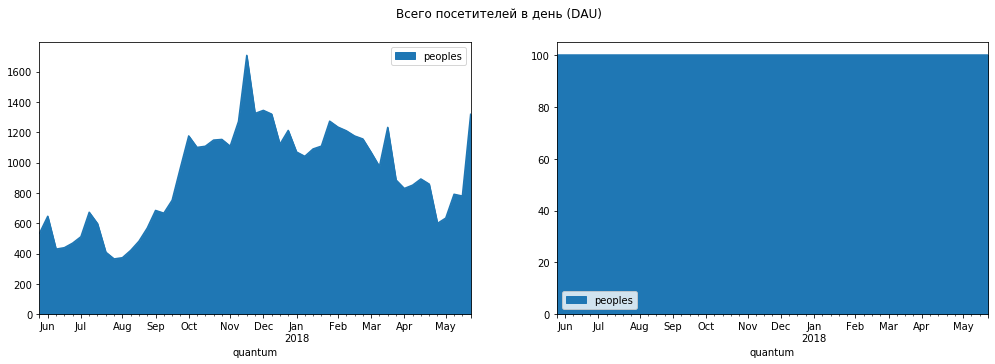

In [9]:
show_html_tag('h3', 'Статистика уникальных посететителей в день (DAU)')    
display(visits_df)
period_stat(visits_df, 'day', 'source_id', 'Посетителей в день (DAU) по source_id', 'nunique')
period_stat(visits_df, 'day', 'device', 'Посетителей в день (DAU) по устройствам', 'nunique')
period_stat(visits_df, 'day', '', 'Всего посетителей в день (DAU)', 'nunique')

### Вывод
* Число посетителей в день (DAU) стартовало в июне 2017 с 533 человек. В августе 2017 был небольшой провал до 372 и далее к ноябрю 2017 рост до 1706 посетителей в день. Далее пошёл тренд на понижение (с небольшим локальным всплеском в феврале) и к маю 2018 число уникальных посетителей в день упало до 779 с необъяснимым пиком в последнюю неполную неделю наблюдения до 1318. Среднее значение DAU за весь анализируемый период 908.
* При рассмотрении разреза по устройствам видно, что за исследуемый период пропорция десктоп/тач колебалась не сильно: от 75/25 (август 2017) до 70/30 (май 2018). Тренд на таком колебании вычленить сложно, но всё же есть некоторый намёк на снижение доли десктопов.
* Разрез по источникам показывает, что в среднем более 50% заходов совершается с источников 3 и 4. При этом по источнику 3 наблюдается медленное падение от 28% до 22%, а по источнику 4 рост от 24% до 30% с локальным всплеком до 32% в январе 2018. Стабильно выше 10% держится доля у заходов с источников 2 и 5. Чуть меньше 10% у источника 1.

source_id,1,2,3,4,5,6,7,9,10
quantum,,,,,,,,,
2017-05-01,163.00,259.00,614.00,510.00,415.00,nan,nan,102.00,65.00
2017-06-01,246.25,402.00,965.25,850.00,685.50,1.00,1.00,176.50,98.50
2017-07-01,252.00,431.20,905.80,925.60,809.80,nan,1.00,135.40,65.80
2017-08-01,217.50,352.50,855.75,757.75,781.75,1.00,1.00,149.50,63.50
2017-09-01,378.00,593.25,1417.75,1351.75,1235.00,1.00,1.50,204.25,125.50
2017-10-01,551.80,884.80,1984.20,2306.40,1712.60,nan,1.25,241.40,206.80
2017-11-01,762.75,1138.75,2468.25,2780.75,1547.50,1.00,2.00,387.25,220.75
2017-12-01,706.25,976.50,2147.00,2801.75,1464.75,1.00,2.00,316.25,148.75
2018-01-01,554.80,833.00,2010.40,2435.20,1358.40,1.00,1.25,253.40,232.60


source_id,1,2,3,4,5,6,7,9,10
quantum,,,,,,,,,
2017-05-01,7.66,12.17,28.85,23.97,19.50,nan,nan,4.79,3.05
2017-06-01,7.19,11.73,28.17,24.81,20.01,0.03,0.03,5.15,2.88
2017-07-01,7.15,12.23,25.68,26.25,22.96,nan,0.03,3.84,1.87
2017-08-01,6.84,11.08,26.91,23.83,24.58,0.03,0.03,4.70,2.00
2017-09-01,7.12,11.18,26.71,25.47,23.27,0.02,0.03,3.85,2.36
2017-10-01,6.99,11.22,25.15,29.23,21.71,nan,0.02,3.06,2.62
2017-11-01,8.19,12.23,26.51,29.87,16.62,0.01,0.02,4.16,2.37
2017-12-01,8.25,11.40,25.07,32.71,17.10,0.01,0.02,3.69,1.74
2018-01-01,7.22,10.85,26.18,31.71,17.69,0.01,0.02,3.30,3.03


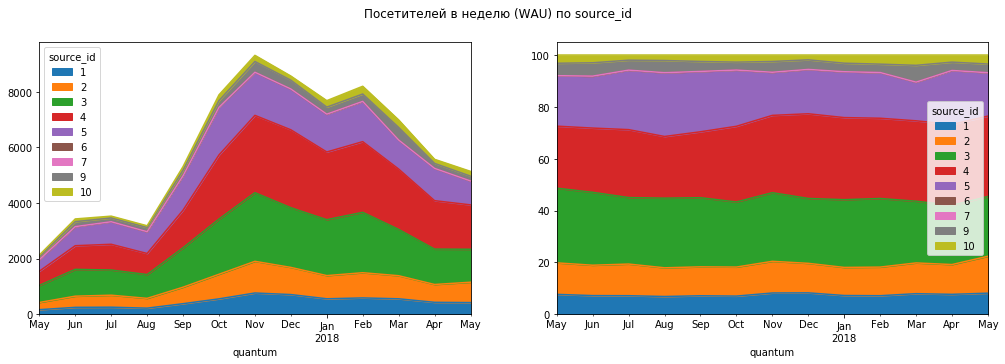

device,desktop,touch
quantum,,
2017-05-01,1451.00,584.00
2017-06-01,2375.25,869.25
2017-07-01,2392.40,935.80
2017-08-01,2204.00,812.00
2017-09-01,3555.50,1441.00
2017-10-01,5278.00,2132.60
2017-11-01,6365.75,2242.50
2017-12-01,5855.00,2117.75
2018-01-01,5077.40,2131.80


device,desktop,touch
quantum,,
2017-05-01,71.30,28.70
2017-06-01,73.21,26.79
2017-07-01,71.88,28.12
2017-08-01,73.08,26.92
2017-09-01,71.16,28.84
2017-10-01,71.22,28.78
2017-11-01,73.95,26.05
2017-12-01,73.44,26.56
2018-01-01,70.43,29.57


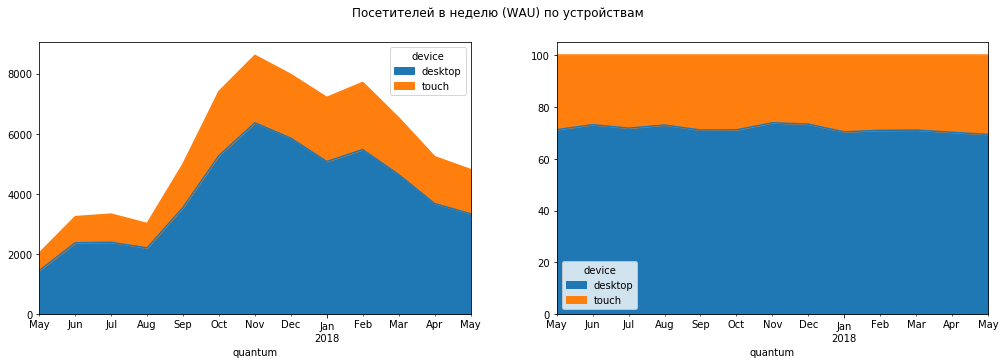

,peoples
quantum,
2017-05-01,2021.00
2017-06-01,3220.75
2017-07-01,3301.80
2017-08-01,3000.00
2017-09-01,4961.50
2017-10-01,7343.00
2017-11-01,8512.00
2017-12-01,7891.75
2018-01-01,7152.80


,peoples
quantum,
2017-05-01,100.00
2017-06-01,100.00
2017-07-01,100.00
2017-08-01,100.00
2017-09-01,100.00
2017-10-01,100.00
2017-11-01,100.00
2017-12-01,100.00
2018-01-01,100.00


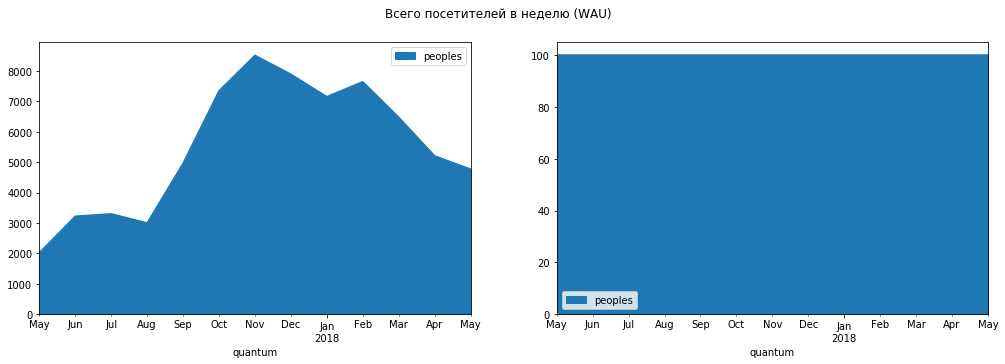

In [10]:
show_html_tag('h3', 'Статистика уникальных посететителей в неделю (WAU)')   

period_stat(visits_df, 'week', 'source_id', 'Посетителей в неделю (WAU) по source_id', 'nunique')
period_stat(visits_df, 'week', 'device', 'Посетителей в неделю (WAU) по устройствам', 'nunique')
period_stat(visits_df, 'week', '', 'Всего посетителей в неделю (WAU)', 'nunique')


### Вывод
Можно сказать, что все тренды и процентные распределения по WAU примерно повторяют предыдущий анализ по DAU. Естественно, абсолютные значения в данном случае больше - стартовали в мае 2017 с 2021 уника в неделю, максимум был в ноябре 2017 - 8512 уников и к маю 2018 число упало до 4771. Среднее значение WAU за весь анализируемый период 5716.


source_id,1,2,3,4,5,6,7,9,10
quantum,,,,,,,,,
2017-06-01,972.00,1532.00,4226.00,3636.00,2903.00,nan,2.00,753.00,427.00
2017-07-01,1047.00,1775.00,4068.00,4114.00,3727.00,1.00,2.00,562.00,316.00
2017-08-01,794.00,1275.00,3416.00,3129.00,3146.00,1.00,1.00,613.00,244.00
2017-09-01,1395.00,2130.00,5825.00,5377.00,4932.00,1.00,3.00,781.00,502.00
2017-10-01,2170.00,3350.00,8533.00,9514.00,7525.00,nan,5.00,1043.00,926.00
2017-11-01,2790.00,4193.00,10190.00,11228.00,6505.00,1.00,1.00,1488.00,888.00
2017-12-01,2735.00,3702.00,9194.00,11787.00,6222.00,1.00,9.00,1234.00,621.00
2018-01-01,2142.00,3168.00,8529.00,10247.00,5738.00,1.00,4.00,1059.00,925.00
2018-02-01,2121.00,3159.00,8686.00,9756.00,5952.00,nan,3.00,1036.00,1088.00


source_id,1,2,3,4,5,6,7,9,10
quantum,,,,,,,,,
2017-06-01,6.73,10.60,29.24,25.16,20.09,nan,0.01,5.21,2.95
2017-07-01,6.71,11.37,26.06,26.35,23.87,0.01,0.01,3.60,2.02
2017-08-01,6.29,10.10,27.07,24.80,24.93,0.01,0.01,4.86,1.93
2017-09-01,6.66,10.17,27.81,25.67,23.55,0.00,0.01,3.73,2.40
2017-10-01,6.56,10.13,25.81,28.77,22.76,nan,0.02,3.15,2.80
2017-11-01,7.48,11.25,27.33,30.11,17.45,0.00,0.00,3.99,2.38
2017-12-01,7.70,10.43,25.89,33.20,17.52,0.00,0.03,3.48,1.75
2018-01-01,6.73,9.96,26.81,32.21,18.04,0.00,0.01,3.33,2.91
2018-02-01,6.67,9.93,27.31,30.68,18.72,nan,0.01,3.26,3.42


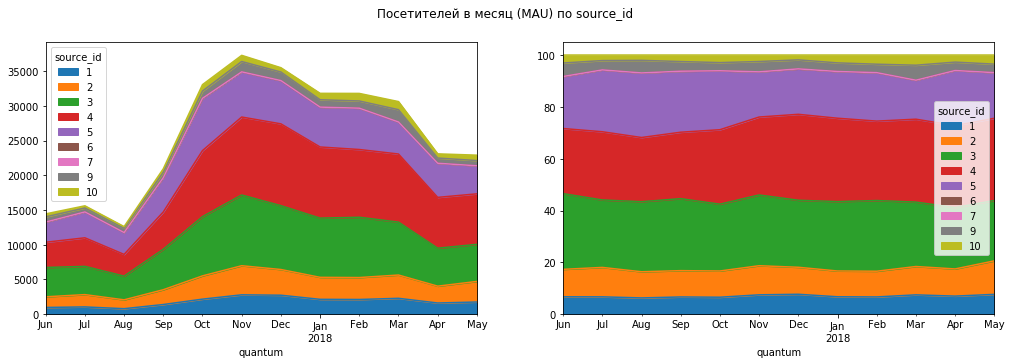

device,desktop,touch
quantum,,
2017-06-01,9761,3655
2017-07-01,10145,4223
2017-08-01,8611,3132
2017-09-01,13509,5679
2017-10-01,21286,8856
2017-11-01,24439,8913
2017-12-01,23294,8785
2018-01-01,20350,8741
2018-02-01,20574,8590


device,desktop,touch
quantum,,
2017-06-01,72.76,27.24
2017-07-01,70.61,29.39
2017-08-01,73.33,26.67
2017-09-01,70.40,29.60
2017-10-01,70.62,29.38
2017-11-01,73.28,26.72
2017-12-01,72.61,27.39
2018-01-01,69.95,30.05
2018-02-01,70.55,29.45


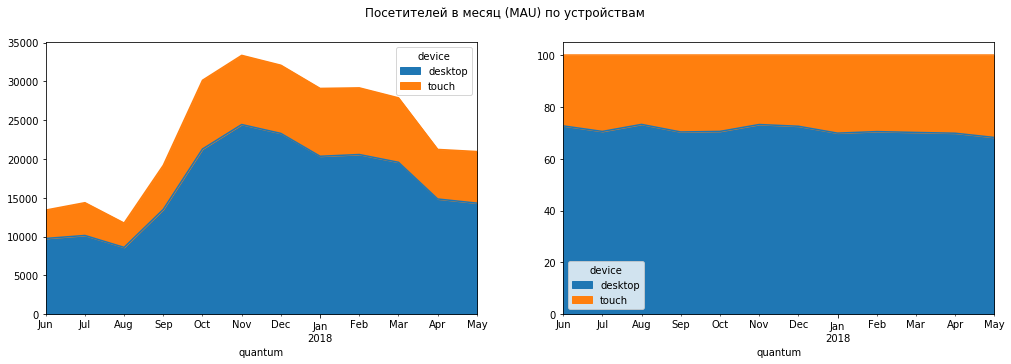

,peoples
quantum,
2017-06-01,13259
2017-07-01,14183
2017-08-01,11631
2017-09-01,18975
2017-10-01,29692
2017-11-01,32797
2017-12-01,31557
2018-01-01,28716
2018-02-01,28749


,peoples
quantum,
2017-06-01,100.00
2017-07-01,100.00
2017-08-01,100.00
2017-09-01,100.00
2017-10-01,100.00
2017-11-01,100.00
2017-12-01,100.00
2018-01-01,100.00
2018-02-01,100.00


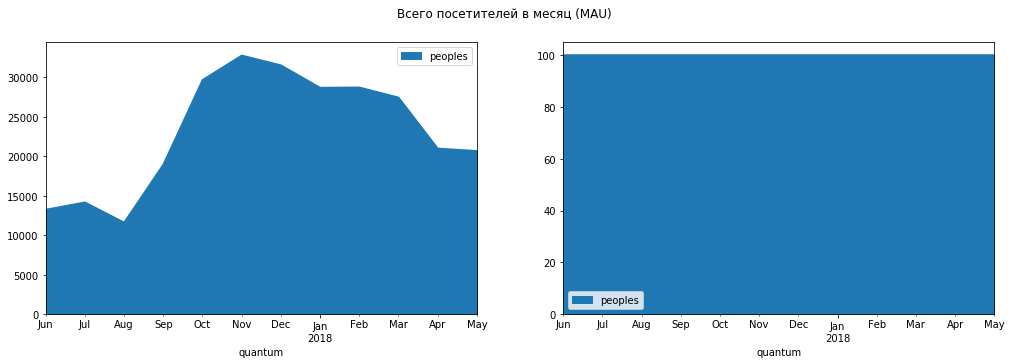

In [11]:
show_html_tag('h3', 'Статистика уникальных посететителей в месяц (MAU)')   

period_stat(visits_df, 'start_ts_month', 'source_id', 'Посетителей в месяц (MAU) по source_id', 'nunique')
period_stat(visits_df, 'start_ts_month', 'device', 'Посетителей в месяц (MAU) по устройствам', 'nunique')
period_stat(visits_df, 'start_ts_month', '', 'Всего посетителей в месяц (MAU)', 'nunique')

### Вывод
И опять все тренды и процентные распределения примерно повторяют анализ по дням. Естественно, абсолютные значения в данном случае больше - стартовали с 13259 уников в мае 2017, максимум был в 32797 уников в ноябре 2017 и к маю 2018 упали до 20701 уников. Среднее значение MAU за весь анализируемый период 23228.

### Сколько сессий в день?

In [12]:
def session_stat(df, period, column, text):
    """Вывод статистики по сессиям одного посетителя в period в разрезе column 
        df - датафрейм с данными
        period - период сбора статистики. совпадает с именем столбца 'day', 'week', 'start_ts_month' в исходном датафрейме
        column - столбец, в разрезе которого строится статистика. Если column == '', то без разреза, по всему датафрейму
        text - выводимый в качестве заголовка текст
    """
    show_html_tag('h4', text)
    
    if column != '':
        session_day = df.groupby([period, column, 'uid']).agg(session = ('uid', 'count')).reset_index()
    else:
        session_day = df.groupby([period, 'uid']).agg(session = ('uid', 'count')).reset_index()


    session_day['month'] = session_day[period].astype('datetime64[M]')

    if column != '':
        session_day_in_month = session_day.pivot_table(index ='month', columns = column, values = 'session', aggfunc='mean')
    else:
        session_day_in_month = session_day.pivot_table(index ='month', values = 'session', aggfunc='mean')

    display(session_day_in_month)

    session_day_in_month.plot.line(ylim=(0.99, 1.2), figsize=(8,5))

    plt.show()
    

source_id,1,2,3,4,5,6,7,9,10
month,,,,,,,,,
2017-06-01,1.18,1.08,1.01,1.02,1.04,nan,1.00,1.01,1.03
2017-07-01,1.17,1.09,1.01,1.02,1.04,1.00,1.00,1.01,1.01
2017-08-01,1.13,1.07,1.01,1.01,1.03,1.00,1.00,1.01,1.05
2017-09-01,1.13,1.08,1.01,1.02,1.05,1.00,1.00,1.01,1.02
2017-10-01,1.14,1.07,1.01,1.02,1.05,nan,1.00,1.01,1.02
2017-11-01,1.19,1.09,1.01,1.02,1.05,1.00,1.00,1.02,1.06
2017-12-01,1.17,1.10,1.01,1.02,1.05,1.00,1.00,1.01,1.03
2018-01-01,1.16,1.10,1.01,1.02,1.05,1.00,1.00,1.01,1.12
2018-02-01,1.18,1.10,1.01,1.02,1.06,nan,1.00,1.01,1.10


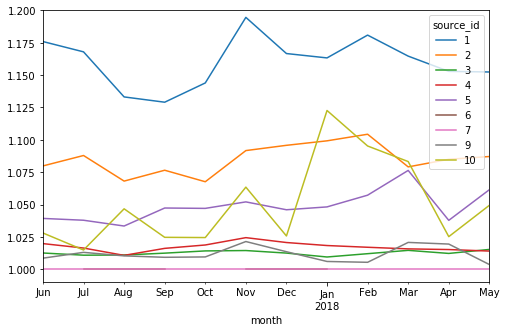

device,desktop,touch
month,,
2017-06-01,1.08,1.04
2017-07-01,1.09,1.05
2017-08-01,1.08,1.04
2017-09-01,1.09,1.05
2017-10-01,1.08,1.05
2017-11-01,1.10,1.08
2017-12-01,1.09,1.07
2018-01-01,1.10,1.05
2018-02-01,1.10,1.05


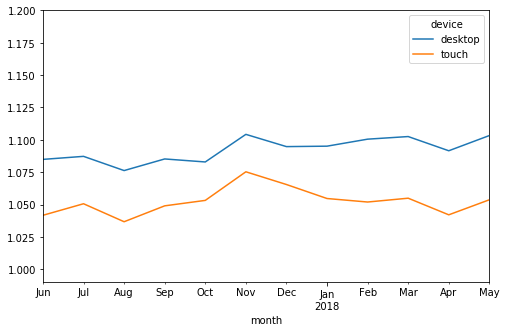

,session
month,
2017-06-01,1.08
2017-07-01,1.08
2017-08-01,1.07
2017-09-01,1.08
2017-10-01,1.08
2017-11-01,1.10
2017-12-01,1.09
2018-01-01,1.09
2018-02-01,1.09


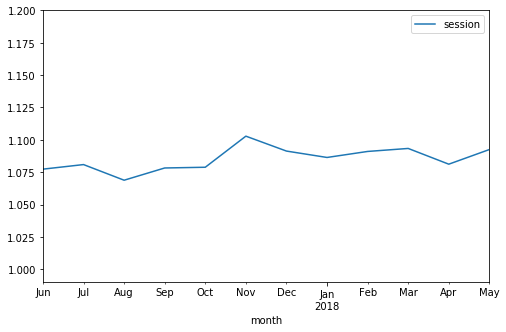

In [13]:
session_stat(visits_df, 'day', 'source_id', 'Сессий одного пользователя в день по source_id')
session_stat(visits_df, 'day', 'device', 'Сессий в день одного пользователя по устройствам')
session_stat(visits_df, 'day', '', 'Сессий одного пользователя в день')    

### Вывод
* Среднее число сессий одного пользователя без привязки с источникам и устройствам, колеблется в интервале 1.07..1.1 без ярко выраженного тренда.
* В разрезе устройств видно, что среднее число сессий с десктопов больше, чем с тач устройств - 1.08..1.10 против 1.04..1.08
* В разрезе источников получаем, что самое большое число сессий у источника 1 - до 1.18. Достаточно большой этот показатель у источников 2 и 5 - до 1.1 и 1.08 соответсвенно. У источника 10 наблюдается очень странный разброс - от 1.01 в ноябре 2017 до 1.12 в январе 2018

### Сколько длится одна сессия?

In [14]:
visits_df['session_duration'] = (visits_df['end_ts']-visits_df['start_ts'])/ np.timedelta64(1, 's')
visits_df.loc[visits_df.loc[:,'session_duration'] < 0 , 'session_duration'] += 3600

In [15]:
def session_duration_stat(df, column, text):
    """Вывод статистики по продолжительности сессий в разрезе column 
        df - датафрейм с данными
        column - столбец, в разрезе которого строится статистика. Если column == '', то без разреза, по всему датафрейму
        text - выводимый в качестве заголовка текст
    """
    show_html_tag('h4', text)

    if column != '':
        session_duration_in_month_mean = df.pivot_table(index ='start_ts_month', columns = column, 
                                                        values = 'session_duration', aggfunc='mean')
        session_duration_in_month_median = df.pivot_table(index ='start_ts_month', columns = column, 
                                                          values = 'session_duration', aggfunc='median')
    else:
        session_duration_in_month_mean = df.pivot_table(index ='start_ts_month', 
                                                        values = 'session_duration', aggfunc='mean')
        session_duration_in_month_median = df.pivot_table(index ='start_ts_month', 
                                                          values = 'session_duration', aggfunc='median')

    show_html_tag('h5', 'средняя')
    display(session_duration_in_month_mean)
    show_html_tag('h5', 'медиана')
    display(session_duration_in_month_median)
    
    fig, ax = plt.subplots(ncols = 2, figsize=(17,5))


    
    session_duration_in_month_mean.plot.line(ylim = (0, 1300), ax = ax[0])
    session_duration_in_month_median.plot.line(ylim = (0, 1300), ax = ax[1])
    ax[0].set_title('Средняя продолжительность сессии')
    ax[1].set_title('Медианная продолжительность сессии')
    plt.show()    

source_id,1,2,3,4,5,6,7,9,10
start_ts_month,,,,,,,,,
2017-06-01,978.10,851.12,511.94,519.26,492.35,nan,150.00,467.14,639.95
2017-07-01,1123.96,836.70,500.72,503.75,488.04,360.00,420.00,518.48,563.23
2017-08-01,1090.50,793.43,506.75,488.92,489.83,180.00,5280.00,551.96,498.81
2017-09-01,939.60,814.18,524.62,539.34,495.22,0.00,780.00,565.88,589.15
2017-10-01,955.56,773.16,561.28,568.52,511.70,nan,264.00,583.24,611.89
2017-11-01,1212.12,904.85,628.56,622.54,542.15,480.00,300.00,651.88,701.87
2017-12-01,1064.05,883.93,628.81,625.92,565.12,1260.00,673.33,573.02,592.56
2018-01-01,998.02,911.08,583.33,555.75,557.63,5940.00,420.00,501.42,772.64
2018-02-01,1055.97,878.28,558.66,555.89,541.34,nan,132.00,540.80,689.88


source_id,1,2,3,4,5,6,7,9,10
start_ts_month,,,,,,,,,
2017-06-01,540.00,360.00,240.00,240.00,240.00,nan,150.00,240.00,360.00
2017-07-01,540.00,360.00,240.00,240.00,240.00,360.00,420.00,240.00,300.00
2017-08-01,540.00,360.00,240.00,240.00,240.00,180.00,5280.00,240.00,240.00
2017-09-01,540.00,420.00,240.00,240.00,240.00,0.00,1080.00,300.00,300.00
2017-10-01,540.00,360.00,240.00,300.00,240.00,nan,120.00,300.00,300.00
2017-11-01,720.00,420.00,300.00,300.00,240.00,480.00,300.00,300.00,300.00
2017-12-01,600.00,420.00,300.00,300.00,240.00,1260.00,720.00,240.00,240.00
2018-01-01,540.00,420.00,240.00,240.00,240.00,5940.00,150.00,240.00,360.00
2018-02-01,600.00,420.00,240.00,240.00,240.00,nan,120.00,240.00,300.00


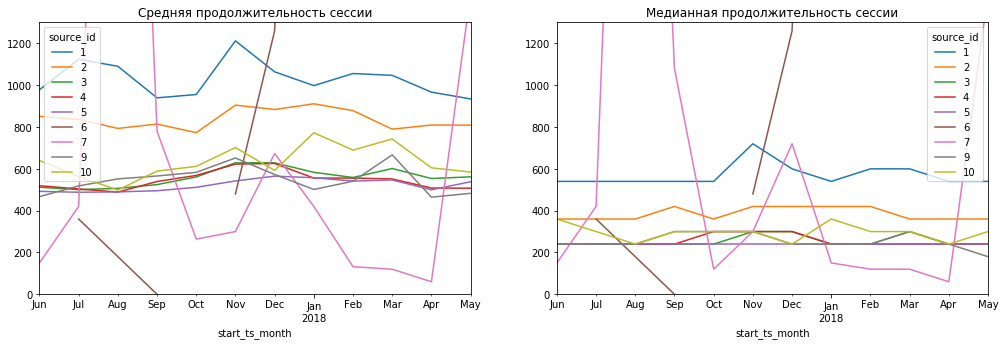

device,desktop,touch
start_ts_month,,
2017-06-01,647.17,459.52
2017-07-01,666.40,440.66
2017-08-01,645.79,413.31
2017-09-01,657.74,436.77
2017-10-01,668.38,474.03
2017-11-01,765.03,559.67
2017-12-01,750.35,535.34
2018-01-01,722.61,474.47
2018-02-01,710.52,469.98


device,desktop,touch
start_ts_month,,
2017-06-01,300.00,180.00
2017-07-01,300.00,180.00
2017-08-01,300.00,180.00
2017-09-01,300.00,180.00
2017-10-01,360.00,180.00
2017-11-01,360.00,240.00
2017-12-01,360.00,240.00
2018-01-01,360.00,180.00
2018-02-01,360.00,180.00


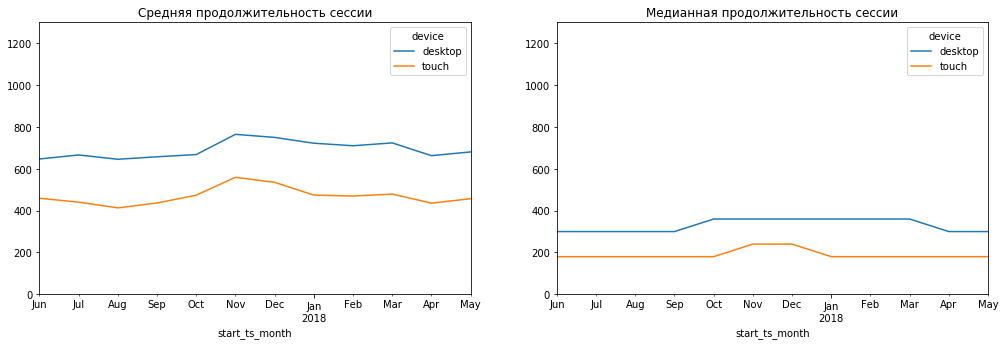

,session_duration
start_ts_month,
2017-06-01,600.02
2017-07-01,604.64
2017-08-01,589.09
2017-09-01,597.19
2017-10-01,614.49
2017-11-01,713.41
2017-12-01,694.68
2018-01-01,653.00
2018-02-01,645.15


,session_duration
start_ts_month,
2017-06-01,300.00
2017-07-01,300.00
2017-08-01,240.00
2017-09-01,300.00
2017-10-01,300.00
2017-11-01,300.00
2017-12-01,300.00
2018-01-01,300.00
2018-02-01,300.00


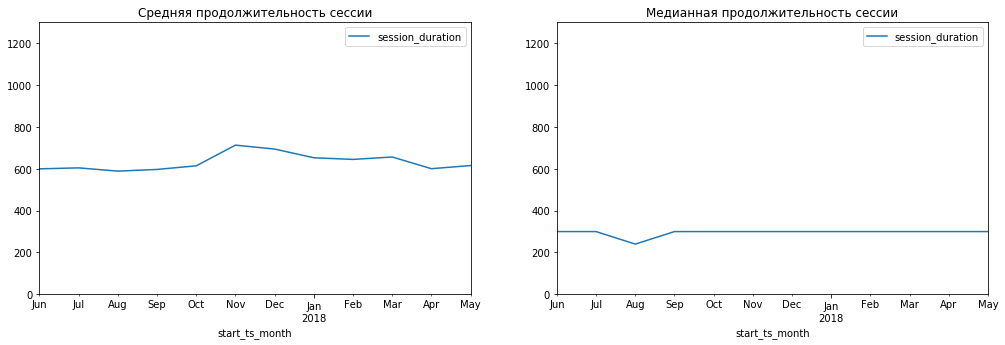

In [16]:
session_duration_stat(visits_df, 'source_id', 'Длина сессии в разрезе источников')
session_duration_stat(visits_df, 'device', 'Длина сессии в разрезе устройств')
session_duration_stat(visits_df, '', 'Средняя длина всех сессий')

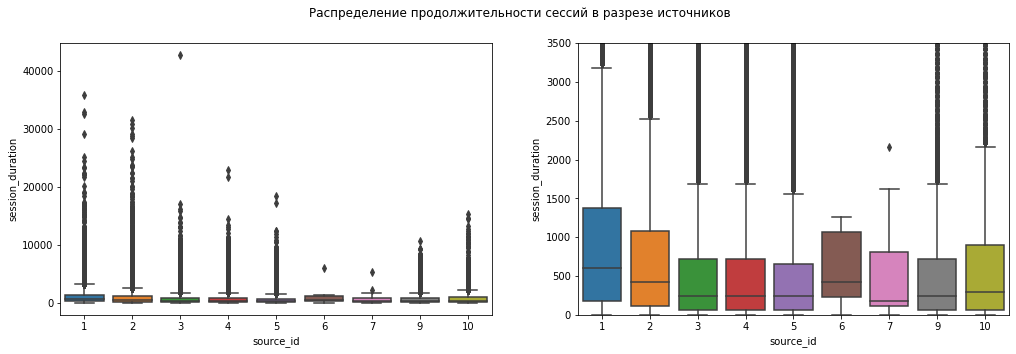

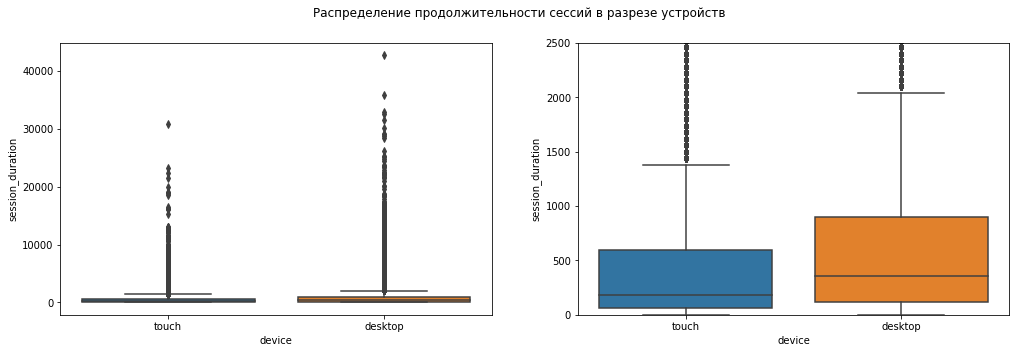

In [17]:
fig, ax = plt.subplots(ncols = 2, figsize=(17,5))

fig.suptitle("Распределение продолжительности сессий в разрезе источников")
sns.boxplot( x=visits_df["source_id"], y=visits_df["session_duration"], ax = ax[0])
ax[1].set(ylim=(0, 3500))
sns.boxplot( x=visits_df["source_id"], y=visits_df["session_duration"], ax = ax[1])
plt.show()

fig, ax = plt.subplots(ncols = 2, figsize=(17,5))
fig.suptitle("Распределение продолжительности сессий в разрезе устройств")
sns.boxplot( x=visits_df["device"], y=visits_df["session_duration"], ax = ax[0])
ax[1].set(ylim=(0, 2500))
sns.boxplot( x=visits_df["device"], y=visits_df["session_duration"], ax = ax[1])
plt.show()


### Вывод
* Имеется 2 записи 25.03.2018 в 3 часа ночи с отрицательной длиной. Вероятнее всего, это последствия перевода часов на 1 час назад при переходе на летнее время. Увеличим длину этих сессий на 1 час.
* Средняя продолжительность сессии по всем устройствам и источникам колеблется в интервале 597..713 без явновыраженного тренда изменений за период наблюдения.
* Медиана во всех разрезах меньше примерно в полтора-два раза, что говорит о наличии значительных выбросов по продолжительности. Это подтверждается и визуалицией боксплотами.
* Средняя продолжительность сессий на десктопе примерно на 200..250 секунд выше, чем на тачу устройствах - (650..750) против (413..560).


### Как часто люди возвращаются?

In [18]:
first_activity_month = visits_df.groupby(['uid'])['start_ts_month'].min()
first_activity_month.name = 'first_activity_month'
visits_df = visits_df.join(first_activity_month,on='uid')
visits_df['cohort_lifetime'] = ((visits_df['start_ts_month'] - visits_df['first_activity_month'])/ np.timedelta64(1,'M'))\
                                    .round().astype('int')

In [19]:
def calc_rr(df, text):
    show_html_tag('h4', text)
    cohorts = df.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
    initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
    cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',\
                                          values='retention',aggfunc='sum')\
                                          .iloc[:,1:]

    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    
    #фиксируем vmax=0.09 специально чтобы иметь одинаковую гамму на всех картах
    ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.09,\
                                yticklabels = retention_pivot.index.strftime('%Y-%m'))
    ax.set(xlabel='Месяц жизни когорты', ylabel='Когорта')
    plt.show()

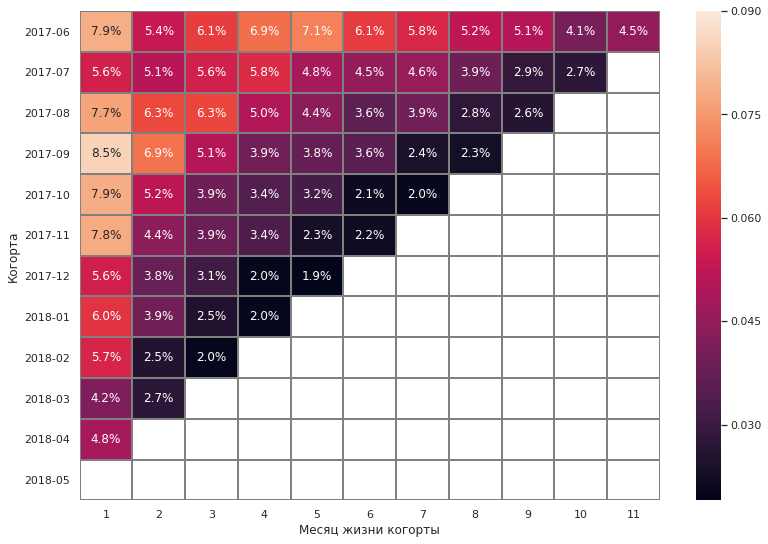

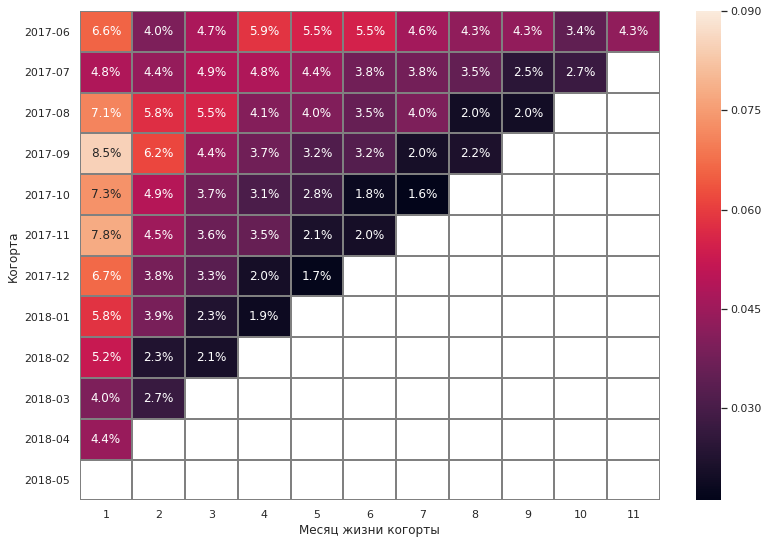

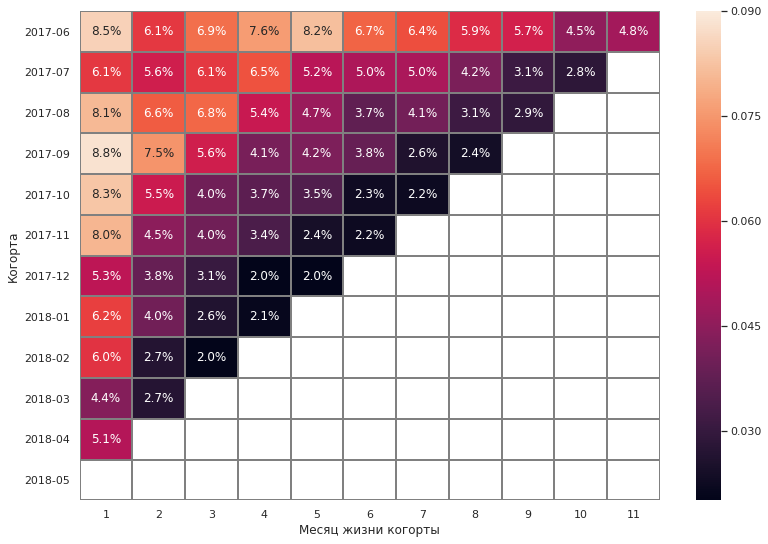

In [20]:
calc_rr(visits_df, 'Общий RR')
for device in visits_df['device'].unique():
    calc_rr(visits_df.query('device==@device'), 'RR по устройствам типа '+ device)

### Вывод
Общий RR: Во второй месяц возвращаются от 4.2% в марте 2018 до 8.5% в сентябре 2018. В последующие месяцы идёт падение до 2%. При этом, чем более позднюю когорту берём, тем быстрее в среднем происходит падение.

В разрезе устройств: в среднем, на десктопах RR несколько выше. От пары процентов во второй месяц, до долей процентов в последние месяцы наблюдения когорт.

Разрез по источникам, кажется, делать нет смысла - пользователи могут активно менять источник в процессе жизни (если потребуется, то сделать по аналогии с устройствами просто - даже цикл ради этого написал).

## Изучаем продажи


### Когда люди начинают покупать?

In [21]:
visits_grouped = visits_df.groupby('uid').agg(date_first_vizit = ('start_ts', 'min'))
orders_min_date = orders_df.groupby('uid').agg(date_first_orders = ('buy_ts', 'min'))
orders_min_date = orders_min_date.join(visits_grouped, how='inner')
orders_min_date['delta_order'] = ((orders_min_date['date_first_orders'] - orders_min_date['date_first_vizit'])\
                                  /np.timedelta64(1,'h'))

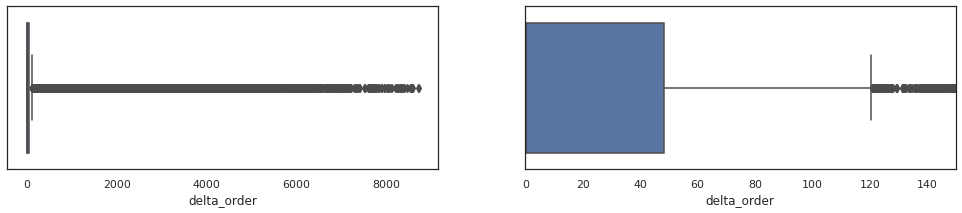

,delta_order
count,36523.00
mean,405.67
std,1129.75
min,0.00
25%,0.07
50%,0.27
75%,48.28
max,8719.07


Процент первых покупок, сделанных в первые сутки после захода: 72%
Процент первых покупок, сделанных в первую неделю после захода: 80%


In [22]:
fig, ax =plt.subplots(1, 2, figsize = (17,3))
sns.boxplot(x=orders_min_date['delta_order'], ax = ax[0])
ax[1].set_xlim([-0.3, 150]) 
sns.boxplot(x=orders_min_date['delta_order'], ax = ax[1])
plt.show()
display(orders_min_date.describe())

print('Процент первых покупок, сделанных в первые сутки после захода: {:.0%}'\
      .format(len(orders_min_date.query('delta_order <= 24'))/len(orders_min_date)))
print('Процент первых покупок, сделанных в первую неделю после захода: {:.0%}'\
      .format(len(orders_min_date.query('delta_order <= 168'))/len(orders_min_date)))

### Вывод
* 50% первых покупок делается в течение 16 минут от первого захода.
* в первые сутки совершается 72% первых покупок

Примечание: сначала пытался посчитать номер сессии у первой покупки (как рекомендовала Ольга Матушевич), но для более чем 7 тысяч покупок не получилось сопоставить запись из лога визитов. Посчитал эту погрешность слишком большой.

### Сколько раз покупают за период?

In [23]:
first_order_month = orders_df.groupby(['uid'])['buy_ts_month'].min()
first_order_month.name = 'first_order_month'
orders_df = orders_df.join(first_order_month,on='uid')
orders_df['cohort_lifetime'] = ((orders_df['buy_ts_month'] - orders_df['first_order_month'])/ np.timedelta64(1,'M'))\
                                    .round().astype('int')

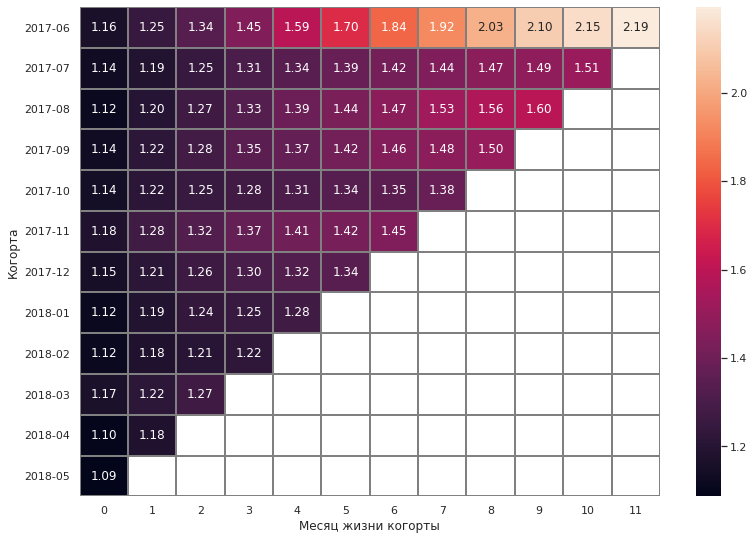

За 6 месяцев среднее число покупок на одного покупателя: 1.43


In [24]:
cohorts = orders_df.groupby(['first_order_month','cohort_lifetime']).agg(orders = ('uid', 'count')).reset_index()
initial_users_count = orders_df.query('cohort_lifetime == 0').groupby('first_order_month').agg(users = ('uid', 'nunique'))\
                                                                                                            .reset_index()
orders_pivot = cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='orders',aggfunc='sum')\
                                                                                            .cumsum(axis=1).reset_index()
orders_pivot = orders_pivot.merge(initial_users_count,on='first_order_month')
orders_pivot = orders_pivot.query('first_order_month != "2018-06-01"') #удаляем ошмётки в июне

for i in range(12):
    orders_pivot[i] = orders_pivot[i]/orders_pivot['users']
orders_pivot = orders_pivot.drop('users', axis=1).set_index('first_order_month')


sns.set(style='white')
plt.figure(figsize=(13, 9))

ax = sns.heatmap(orders_pivot, annot=True, linewidths=1, linecolor='gray',\
                            yticklabels = orders_pivot.index.strftime('%Y-%m'), fmt='.2f')
ax.set(xlabel='Месяц жизни когорты', ylabel='Когорта')
plt.show()
print('За 6 месяцев среднее число покупок на одного покупателя: {:.2f}'.format(orders_pivot[5].mean()))


### Вывод
* За 6 месяцев в среднем один покупатель делает 1.43 покупки


### Какой средний чек?

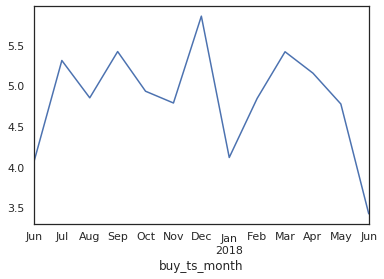

,0,1,2,3,4,5,6,7,8,9,10,11,12
buy_ts_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
revenue,4.06,5.31,4.85,5.42,4.93,4.78,5.85,4.11,4.84,5.41,5.15,4.77,3.42


Средний чек: 5.00


In [25]:
avg_pays = orders_df.groupby('buy_ts_month')['revenue'].mean()
avg_pays.plot()
plt.show()
avg_pays = avg_pays.reset_index()
avg_pays['buy_ts_month'] =  avg_pays['buy_ts_month'].dt.strftime('%Y-%m')
display(avg_pays.T)
print('Средний чек: {:.2f}'.format(orders_df['revenue'].mean()))

### Вывод
* Средний чек равен ровно 5. Помесячно колеблется от 3.42 до 5.85 без явно выраженного тренда изменений, но с сильным падением в июне 2018.

### Сколько денег приносят? (LTV)

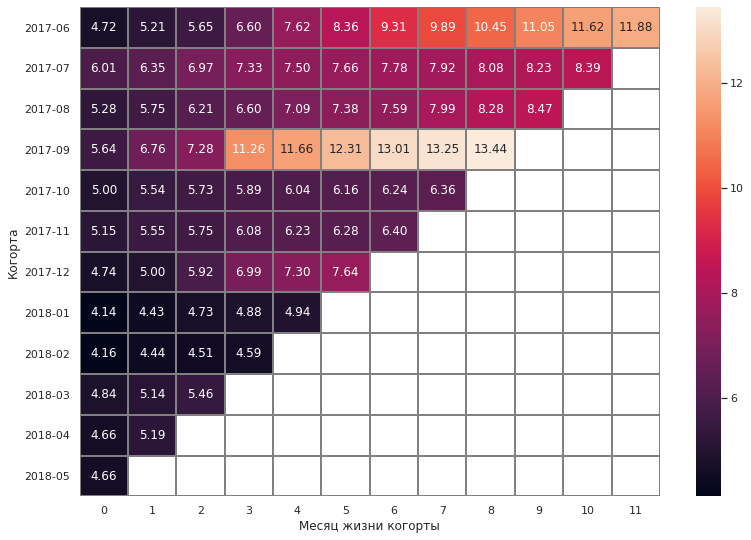

За 6 месяцев средняя выручка с одного покупателя: 7.97


In [26]:
cohorts = orders_df.groupby(['first_order_month','cohort_lifetime']).agg(sum_revenue = ('revenue', 'sum')).reset_index()
initial_users_count = orders_df.query('cohort_lifetime == 0').groupby('first_order_month').agg(users = ('uid', 'nunique'))\
                                                                                                            .reset_index()
orders_pivot = cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='sum_revenue',aggfunc='sum')\
                                                                                            .cumsum(axis=1).reset_index()
orders_pivot = orders_pivot.merge(initial_users_count,on='first_order_month')
orders_pivot = orders_pivot.query('first_order_month != "2018-06-01"') #удаляем ошмётки в июне


for i in range(12):
    orders_pivot[i] = orders_pivot[i]/orders_pivot['users']
orders_pivot = orders_pivot.drop('users', axis=1).set_index('first_order_month')


sns.set(style='white')
plt.figure(figsize=(13, 9))

ax = sns.heatmap(orders_pivot, annot=True, linewidths=1, linecolor='gray',\
                            yticklabels = orders_pivot.index.strftime('%Y-%m'), fmt='.2f')
ax.set(xlabel='Месяц жизни когорты', ylabel='Когорта')
plt.show()
print('За 6 месяцев средняя выручка с одного покупателя: {:.2f}'.format(orders_pivot[5].mean()))

### Вывод
* Средний LTV по разным когортам покупателя за 6 месяцев равен 7.97. При этом по когортам колеблется от 6.16 до 12.31

## Изучаем маркетинг

### Сколько денег потратили? Всего / на каждый источник / по времени

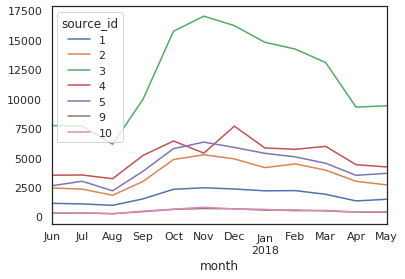

source_id,1,2,3,4,5,9,10,Итого
2017-06,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22,18015.00
2017-07,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82,18240.59
2017-08,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57,14790.54
2017-09,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67,24368.91
2017-10,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24,36322.88
2017-11,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36,37907.88
2017-12,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86,38315.35
2018-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35,33518.52
2018-02,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88,32723.03
2018-03,1893.09,3943.14,13080.85,5961.87,4528.92,480.29,526.41,30414.57


In [27]:
visits_grouped = visits_df.groupby(['day','source_id']).agg(count_visits=('uid','count')).reset_index()
visits_grouped = visits_grouped.merge(costs_df, left_on=['day','source_id'], right_on=['dt', 'source_id'])
# внезапно обнаружил, что неправильно понимал смысл столбца 'cost'. чтобы не переписывать всю логику, 
# проще сделать одно глупое присваивание
visits_grouped['sum'] = visits_grouped['costs'];
visits_grouped['month'] = visits_grouped['day'].astype('datetime64[M]')

visits_pivot = visits_grouped.pivot_table(index='month',columns='source_id',values='sum',aggfunc='sum')
visits_pivot.plot()
plt.show()
visits_pivot['Итого'] = visits_pivot.sum(axis=1)
visits_pivot.index = visits_pivot.index.strftime('%Y-%m')
visits_pivot.loc['Итого']= visits_pivot.sum()

display(visits_pivot)


## Вывод
* Всего на маркетинг потрачено 329К
* Больше всего потратили в ноябре и декабре 2017 - по 38К. Меньше всего в августе 2017 - менее 15К
* В разрезе источников самые большие вложения в 3 и 4 - 141К (43%) и 61К (19%) соответственно

### Сколько стоило привлечение одного покупателя из каждого источника?

Допущение: источник покупателя определяю как источник его самого первого захода. Это связано с тем, что далеко не для всех покупок можно определить конкретную сессию по логу visits. Цену привлечения так же беру в день первого захода

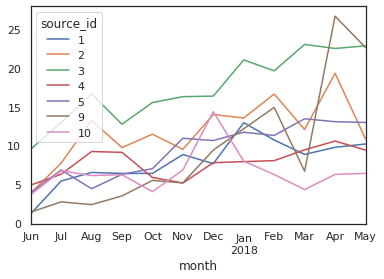

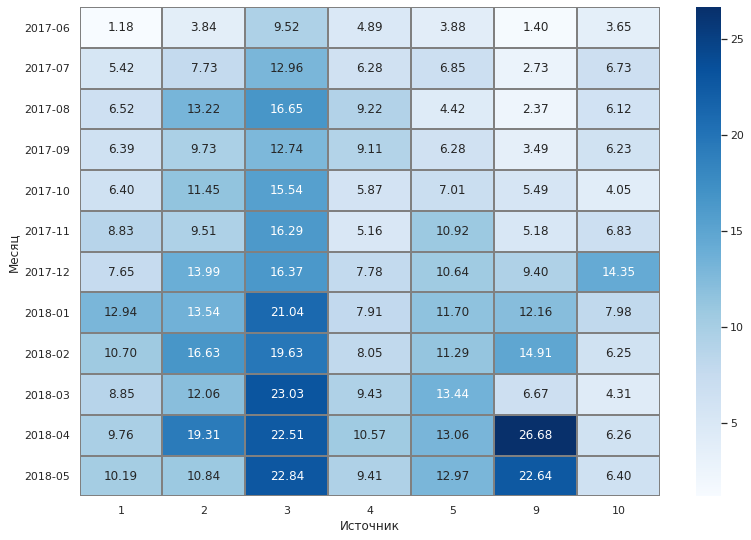

Средняя стоимость привлечения одного покупателя: 10.28


In [28]:
# 1. посчитаем число привлечённых покупателей в день (помним, что привлечение мы считаем по первому входу, несмотря на то, 
#     что покупка может быть сильно позже)
# 2. объединим привлечённых покупателей и траты в одну таблицу
# 3. агрегируем всё помесячно в разрезе источников


# 1. посчитаем число привлечённых покупателей в день (помним, что привлечение мы считаем по первому входу, несмотря на то, 
#     что покупка может быть сильно позже)
visits_df['num_of_session'] = visits_df.sort_values(['uid','start_ts'], ascending=[True,True])\
                                .groupby(['uid']).cumcount()
orders_df['num_of_orders'] = visits_df.sort_values(['uid','start_ts'], ascending=[True,True])\
                                .groupby(['uid']).cumcount()

#         скрещиваем первый визит и первый ордер
visits_first = visits_df.query('num_of_session == 0').filter(['source_id', 'uid', 'day'])

orders_and_visits = orders_df.query('num_of_orders == 0').merge(visits_first, on=['uid'])\
                                .filter(['source_id', 'day'])
buyers = orders_and_visits.groupby(['source_id','day']).agg(count_buyer=('source_id','count')).reset_index()

# 2. объединим привлечённых покупателей и траты в одну таблицу
buyers_and_cost = buyers.merge(costs_df, left_on=['source_id', 'day'], right_on=['source_id', 'dt'], how = 'outer') 

# 3. агрегируем всё помесячно в разрезе источников
buyers_and_cost['month'] = buyers_and_cost['dt'].astype('datetime64[M]')
buyers_and_cost_month = buyers_and_cost.groupby(['month', 'source_id'])\
                            .agg(cost= ('costs', 'sum'), count_buyer = ('count_buyer', 'sum')).reset_index()
buyers_and_cost_month['cost_per_buyer'] = buyers_and_cost_month['cost']/buyers_and_cost_month['count_buyer']

cost_per_buyer_pivot = buyers_and_cost_month.pivot_table(index='month', columns='source_id', values='cost_per_buyer')

# Визуализируем
cost_per_buyer_pivot.plot()

sns.set(style='white')
plt.figure(figsize=(13, 9))

ax = sns.heatmap(cost_per_buyer_pivot, annot=True, linewidths=1, linecolor='gray',\
                            yticklabels = cost_per_buyer_pivot.index.strftime('%Y-%m'), fmt='.2f', cmap='Blues')
ax.set(xlabel='Источник', ylabel='Месяц')
plt.show()
print('Средняя стоимость привлечения одного покупателя: {:.2f}'\
      .format(buyers_and_cost_month['cost'].sum()/buyers_and_cost_month['count_buyer'].sum()))



### Вывод
* Стоимость привлечения растёт со временем. 
* Самый дорогой канал - 3. Самый дешевый - 10
* Средняя стоимость привлечения по всем источникам за все периоды - 10.28

### На сколько окупились расходы? (ROI)

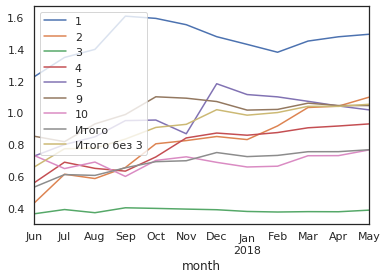

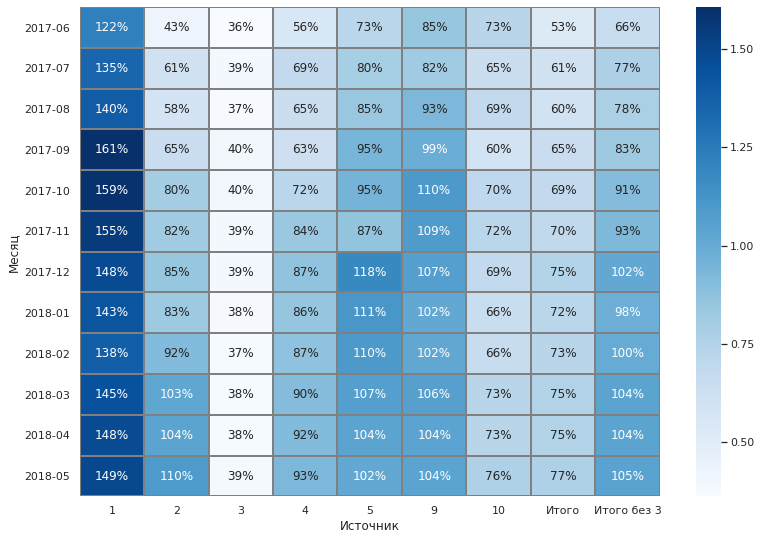

In [29]:
# помесячные траты в разрезе источников есть buyers_and_cost_month
# 1. замерджим ордера с первыми визитами, чтобы получить источник
# 2. сгруппируем по месяцам и источникам, просуммировав revenue
# 3. замерджим с месячными тратами

orders_and_first_visits = orders_df.merge(visits_first, on=['uid'])\
                                .filter(['source_id', 'buy_ts', 'revenue'])
orders_and_first_visits['month'] = orders_and_first_visits['buy_ts'].astype('datetime64[M]')
orders_and_first_visits = orders_and_first_visits.filter(['source_id', 'month', 'revenue'])
orders_and_first_visits_month = orders_and_first_visits.groupby(['month', 'source_id'])\
                                                                .agg(revenue= ('revenue', 'sum')).reset_index()

cost_and_revenue = buyers_and_cost_month.merge(orders_and_first_visits_month, on = ['month', 'source_id'], how='left')

# как-то получается костыльно, но не придумал как лучше
cost_pivot = cost_and_revenue.pivot_table(index='month', columns='source_id', values='cost').cumsum(axis=0)
revenue_pivot = cost_and_revenue.pivot_table(index='month', columns='source_id', values='revenue').cumsum(axis=0)

cost_pivot['Итого'] = cost_pivot.sum(axis=1)
cost_pivot['Итого без 3'] = cost_pivot['Итого'] - cost_pivot[3]


revenue_pivot['Итого'] = revenue_pivot.sum(axis=1)
revenue_pivot['Итого без 3'] = revenue_pivot['Итого'] - revenue_pivot[3]

roi = pd.DataFrame()
for i in [1,2,3,4,5,9,10, 'Итого', 'Итого без 3']:
    roi[i] = revenue_pivot[i] / cost_pivot[i]


# Визуализируем
roi.plot()

sns.set(style='white')
plt.figure(figsize=(13, 9))

#yticklabels = roi.index.strftime('%Y-%m'),
ax = sns.heatmap(roi, annot=True, linewidths=1, linecolor='gray',\
                             yticklabels = roi.index.strftime('%Y-%m'), fmt='.0%', cmap='Blues')
ax.set(xlabel='Источник', ylabel='Месяц')
plt.show()


### Вывод
* Очень выгодный первый канал - маржа к концу периода почти 50%. Неплох канал 2 - маржа 10%. Каналы 5 и 9 на грани рентабельности - маржа 2 и 4 соответсвенно. Хотя у 5 в пике была 118%. Остальные каналы генерируют убыток. Особенно большой убыток у канала 3 - он окупился всего на 39%
* Общий ROI 77%. Хьюстон, у нас проблема... Но тренд на улучшение ситуации со временем виден.
* Если вообще исключить канал 3, ROI к концу периода становится выше 105. Маркетолога, вливающего деньги в канал 3, надо уволить.

## Общий вывод

* Средний DAU = 908, пик был в ноябре 1706.
* Средний WAU = 5718, пик в ноябре 8512
* Средний MAU = 23228, пик в ноябре 32797


* ~ 3/4 заходов с десктопов, оставшиеся с мобильных устройств
* более половины заходов из источников 3 и 4. Более 10% заходов так же от источников 2 и 5


* Среднее число сессий с десктопа больше, чем с тач устройств - 1.08..1.10 против 1.04..1.08
* В разрезе источников самое большое число сессий у источника 1 - до 1.18. Достаточно большой этот показатель у источников 2 и 5 - до 1.1 и 1.08 соответсвенно. У источника 10 наблюдается очень странный разброс - от 1.01 в ноябре 2017 до 1.12 в январе 2018


* Средняя продолжительность сессий на десктопе примерно на 200..250 секунд выше, чем на тач устройствах - (650..750) против (413..560).


* Общий RR: Во второй месяц возвращаются от 4.2% в марте 2018 до 8.5% в сентябре 2018. В последующие месяцы идёт падение до 2%. При этом, чем более позднюю когорту берём, тем быстрее в среднем происходит падение.
* В разрезе устройств: в среднем, на десктопах RR несколько выше. От пары процентов во второй месяц, до долей процентов в последние месяцы наблюдения когорт.


* 50% первых покупок делается в течение 16 минут от первого захода.
* в первые сутки совершается 72% первых покупок
* За 6 месяцев в среднем один покупатель делает 1.43 покупки
* За 6 месяцев средняя выручка с одного покупателя (LTV): 7.97


* Всего на маркетинг потрачено 329К
* Стоимость привлечения растёт со временем.
* Самый дорогой канал - 3. Самый дешевый - 10
* Средняя стоимость привлечения по всем источникам за все периоды - 10.28


* канал 3 категорически невыгодный для привлечения пользователь. В нём самый дорогой покупатель, очень большие объёмы и как итог, и самые большие суммарные убытки. Без этого канала были бы в плюсе (ROI=105%), а так в значительном минусе (ROI=77%). Необходимо кардинально сокращать на него расходы, а может и вообще отключить траты на него
* канал 1 наоборот, очень выгодный. У него максмальный ROI и максимальное число сессий на одного пользователя. Если возможно, то расходы на него стоит увеличить до максимального уровня, контролируя, не упадёт ли прибыльность.
* убыточные каналы 4 и 10 необходимо так же сокращать, в надежде, что стоимость привлечения одного пользователя при этом упадёт и может появится шанс выйти хотя бы в 0 по ним.